In [15]:
import argparse
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import pandas as pd
import zipfile 
from  datetime import datetime
%matplotlib inline

In [16]:
def showim(img):
    imgplot = plt.imshow(img)
    plt.show()

In [17]:
imgs = []
for i in os.listdir('data'):
    imgs.append(cv2.imread('data/' + i ))
    

# SIFT

In [18]:
def eval_kp_detector(kp_extractor, matcher, name):
    kp_0, desc_0 = kp_extractor.detectAndCompute(imgs[0], None)
    match_count = np.zeros(len(kp_0), np.int32)
    frames_repeatability = []

    total_time = 0
    total_kp_count = 0

    for i, im in enumerate(imgs):
        begin_time = datetime.now()
        kp_i, desc_i = kp_extractor.detectAndCompute(im, None)
        end_time = datetime.now()
        total_time += (end_time - begin_time).total_seconds()
        total_kp_count += len(kp_i)
        matches = matcher.match(desc_i, desc_0)

        src_pts = np.float32([kp_0[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_i[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)

        matrix, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)

        frame_match_count = np.zeros(len(kp_0), np.int32)
        for i, has_match in enumerate(mask):
            if has_match == 1:
                frame_match_count[matches[i].trainIdx] += 1
        match_count += frame_match_count
        frames_repeatability.append(np.mean(frame_match_count))

    kp_repeatability = match_count / len(imgs)

    print(f'repeatability in each frame = {frames_repeatability}')
    print(f'avg repeatability = {np.mean(kp_repeatability)}')
    print(f'time per kp = {1000*total_time/total_kp_count} ms')
    fig = plt.figure(figsize=(16,12))
    plt.plot(range(len(imgs)), frames_repeatability)
    plt.title(name)
    plt.xlabel('image number')
    plt.ylabel('repeatability')

    plt.ylim(0,1.05)
    plt.show() 

repeatability in each frame = [1.0, 0.6482084690553745, 0.6482084690553745, 0.5570032573289903, 0.5423452768729642, 0.5390879478827362, 0.5325732899022801, 0.5456026058631922, 0.5700325732899023, 0.5325732899022801, 0.5472312703583062, 0.5374592833876222]
avg repeatability = 0.6000271444082519
time per kp = 0.02969846654905686 ms


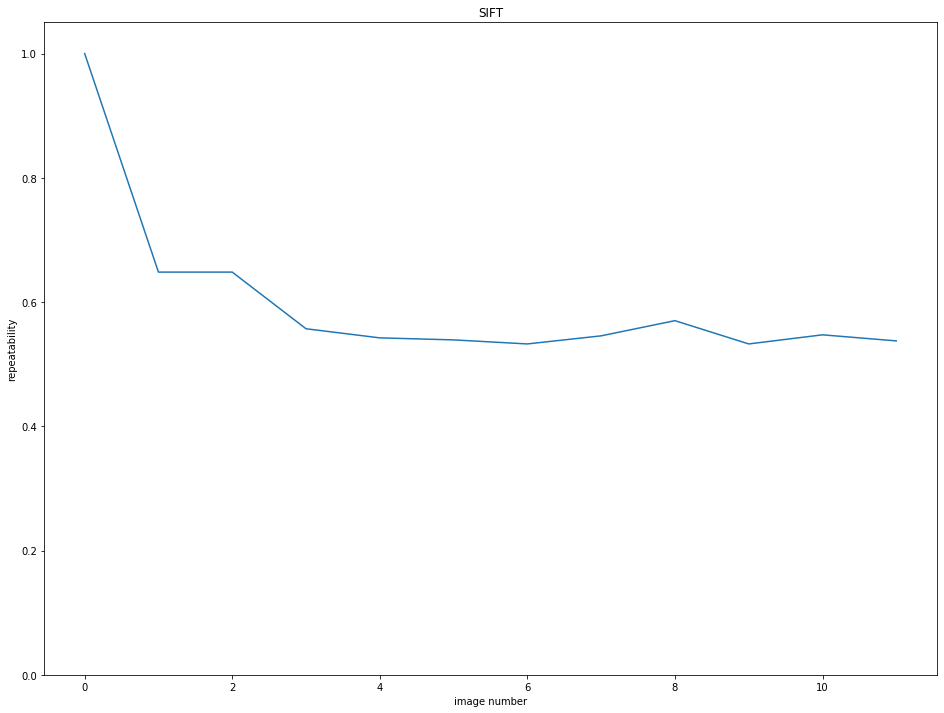

In [19]:
eval_kp_detector(cv2.SIFT_create(),cv2.BFMatcher(cv2.NORM_L1, crossCheck=True),'SIFT')

# ORB

repeatability in each frame = [1.0, 0.606694560669456, 0.5606694560669456, 0.45188284518828453, 0.35564853556485354, 0.4456066945606695, 0.38702928870292885, 0.3723849372384937, 0.3305439330543933, 0.28451882845188287, 0.33472803347280333, 0.39539748953974896]
avg repeatability = 0.46042538354253837
time per kp = 0.00846326601671309 ms


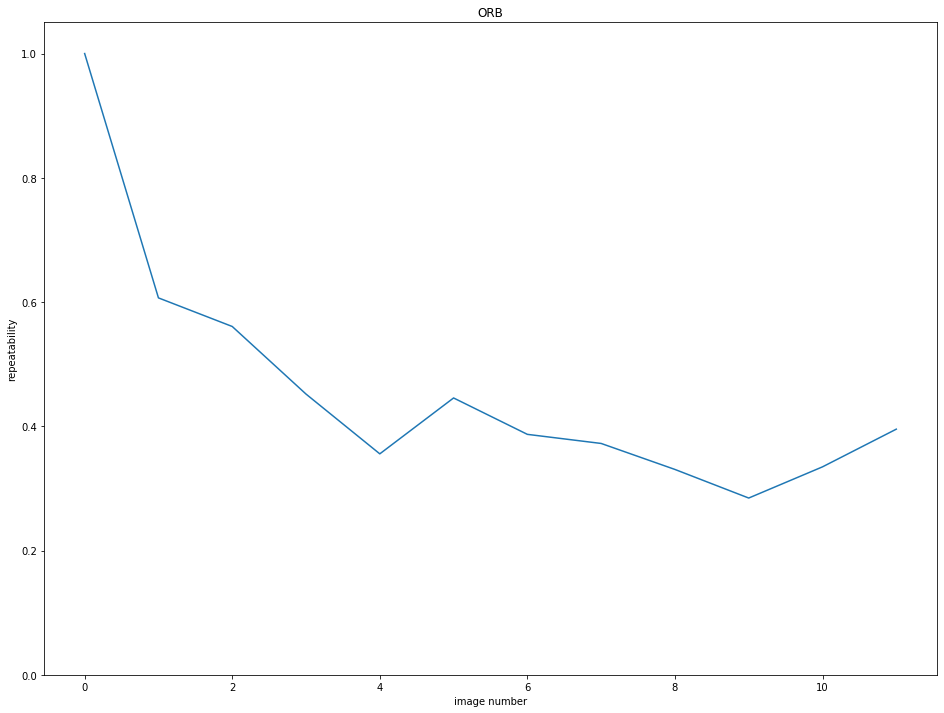

In [20]:
eval_kp_detector(cv2.ORB_create(),cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True),'ORB')

# Shi-Tomasi

repeatability in each frame = [1.0, 0.69, 0.58, 0.64, 0.7, 0.63, 0.57, 0.64, 0.6, 0.62, 0.61, 0.67]
avg repeatability = 0.6625
time per kp = 0.019980833333333333 ms


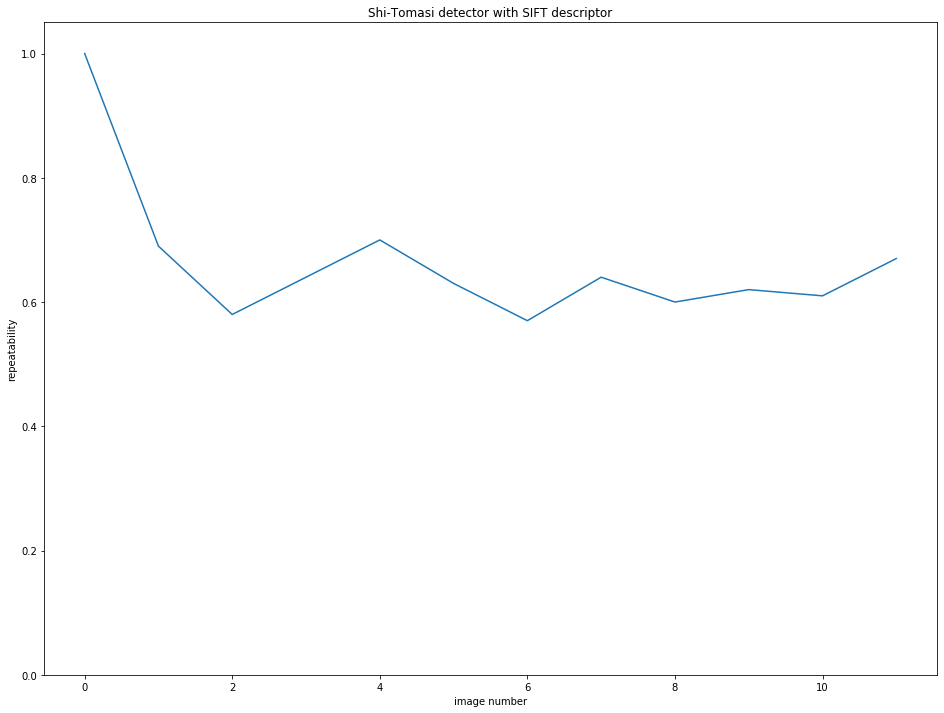

In [21]:
kp_descriptor = cv2.SIFT_create()
matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
name='Shi-Tomasi detector with SIFT descriptor'

def extract(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(img, 100, 0.01, 10)
    kps = [cv2.KeyPoint(c[0][0],c[0][1],50) for c in corners]  
    return kps

kp_0 = extract(imgs[0])
_, desc_0 = kp_descriptor.compute(imgs[0], kp_0)
match_count = np.zeros(len(kp_0), np.int32)
frames_repeatability = []

total_time = 0
total_kp_count = 0

for i, im in enumerate(imgs):
    begin_time = datetime.now()
    kp_i = extract(im)
    end_time = datetime.now()
    _, desc_i = kp_descriptor.compute(im, kp_i)
    total_time += (end_time - begin_time).total_seconds()
    total_kp_count += len(kp_i)
    matches = matcher.match(desc_i, desc_0)

    src_pts = np.float32([kp_0[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_i[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)

    matrix, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)

    frame_match_count = np.zeros(len(kp_0), np.int32)
    for i, has_match in enumerate(mask):
        if has_match == 1:
            frame_match_count[matches[i].trainIdx] += 1
    match_count += frame_match_count
    frames_repeatability.append(np.mean(frame_match_count))

kp_repeatability = match_count / len(imgs)

print(f'repeatability in each frame = {frames_repeatability}')
print(f'avg repeatability = {np.mean(kp_repeatability)}')
print(f'time per kp = {1000*total_time/total_kp_count} ms')
fig = plt.figure(figsize=(16,12))
plt.plot(range(len(imgs)), frames_repeatability)
plt.title(name)
plt.ylim(0,1.05)
plt.xlabel('image number')
plt.ylabel('repeatability')
plt.show() 